# Bank Customer Churn Analysis

## Project Overview
This project analyzes customer churn patterns in banking to identify at-risk customers and provide actionable retention strategies for financial institutions.

**Key Objectives:**
- Identify factors contributing to customer churn
- Analyze churn patterns across different customer segments
- Provide data-driven recommendations for customer retention

**Technologies:** Python, SQL (SQLite), Pandas, Matplotlib, Seaborn

## 1. Setup and Imports

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 11

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 2. Database Connection and Initial Data Load

In [2]:
# Connect to SQLite database
conn = sqlite3.connect('data/bank_churn.db')
print("✓ Connected to database")

# Check available tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(f"\nAvailable tables: {tables['name'].tolist()}")

✓ Connected to database

Available tables: ['customers']


## 3. SQL Queries - Data Extraction

### 3.1 Overall Churn Statistics

In [3]:
# Query: Overall churn rate
query_overall = """
SELECT 
    COUNT(*) as total_customers,
    SUM(CASE WHEN Exited = 1 THEN 1 ELSE 0 END) as churned_customers,
    ROUND(AVG(Exited) * 100, 2) as churn_rate_percent
FROM customers;
"""

overall_stats = pd.read_sql_query(query_overall, conn)
print("Overall Churn Statistics:")
print(overall_stats)

Overall Churn Statistics:
   total_customers  churned_customers  churn_rate_percent
0            10000               2038               20.38


### 3.2 Churn Rate by Geography

In [4]:
# Query: Churn rate by country
query_geography = """
SELECT 
    Geography,
    COUNT(*) as total_customers,
    SUM(Exited) as churned,
    ROUND(AVG(Exited) * 100, 2) as churn_rate
FROM customers
GROUP BY Geography
ORDER BY churn_rate DESC;
"""

churn_by_geo = pd.read_sql_query(query_geography, conn)
print("\nChurn Rate by Geography:")
print(churn_by_geo)


Churn Rate by Geography:
  Geography  total_customers  churned  churn_rate
0   Germany             2509      814       32.44
1     Spain             2477      413       16.67
2    France             5014      811       16.17


### 3.3 Churn by Credit Score Range

In [5]:
# Query: Churn rate by credit score category
query_credit = """
SELECT 
    CASE 
        WHEN CreditScore < 600 THEN 'Poor (< 600)'
        WHEN CreditScore < 700 THEN 'Fair (600-699)'
        WHEN CreditScore < 800 THEN 'Good (700-799)'
        ELSE 'Excellent (800+)'
    END as credit_category,
    COUNT(*) as customers,
    ROUND(AVG(Exited) * 100, 2) as churn_rate,
    ROUND(AVG(CreditScore), 0) as avg_credit_score
FROM customers
GROUP BY credit_category
ORDER BY churn_rate DESC;
"""

churn_by_credit = pd.read_sql_query(query_credit, conn)
print("\nChurn Rate by Credit Score:")
print(churn_by_credit)


Churn Rate by Credit Score:
    credit_category  customers  churn_rate  avg_credit_score
0      Poor (< 600)       3034       21.75             537.0
1    Good (700-799)       2493       19.94             742.0
2    Fair (600-699)       3818       19.72             650.0
3  Excellent (800+)        655       19.54             831.0


### 3.4 Active vs Inactive Members Analysis

In [6]:
# Query: Active vs Inactive member comparison
query_activity = """
SELECT 
    CASE WHEN IsActiveMember = 1 THEN 'Active' ELSE 'Inactive' END as member_status,
    COUNT(*) as total_customers,
    ROUND(AVG(Exited) * 100, 2) as churn_rate,
    ROUND(AVG(Balance), 2) as avg_balance,
    ROUND(AVG(Tenure), 1) as avg_tenure_years
FROM customers
GROUP BY IsActiveMember
ORDER BY churn_rate DESC;
"""

churn_by_activity = pd.read_sql_query(query_activity, conn)
print("\nChurn Rate: Active vs Inactive Members:")
print(churn_by_activity)


Churn Rate: Active vs Inactive Members:
  member_status  total_customers  churn_rate  avg_balance  avg_tenure_years
0      Inactive             4849       26.87     77134.38               5.1
1        Active             5151       14.27     75875.42               4.9


### 3.5 Product Analysis

In [7]:
# Query: Churn by number of products
query_products = """
SELECT 
    NumOfProducts,
    COUNT(*) as customers,
    ROUND(AVG(Exited) * 100, 2) as churn_rate,
    ROUND(AVG(Balance), 2) as avg_balance
FROM customers
GROUP BY NumOfProducts
ORDER BY NumOfProducts;
"""

churn_by_products = pd.read_sql_query(query_products, conn)
print("\nChurn Rate by Number of Products:")
print(churn_by_products)


Churn Rate by Number of Products:
   NumOfProducts  customers  churn_rate  avg_balance
0              1       5084       27.71     98551.87
1              2       4590        7.60     51879.15
2              3        266       82.71     75458.33
3              4         60      100.00     93733.14


### 3.6 Complaint Analysis

In [8]:
# Query: Impact of complaints on churn
query_complain = """
SELECT 
    CASE WHEN Complain = 1 THEN 'Has Complained' ELSE 'No Complaints' END as complaint_status,
    COUNT(*) as customers,
    ROUND(AVG(Exited) * 100, 2) as churn_rate,
    ROUND(AVG([Satisfaction Score]), 2) as avg_satisfaction
FROM customers
GROUP BY Complain
ORDER BY churn_rate DESC;
"""

churn_by_complain = pd.read_sql_query(query_complain, conn)
print("\nChurn Rate by Complaint Status:")
print(churn_by_complain)


Churn Rate by Complaint Status:
  complaint_status  customers  churn_rate  avg_satisfaction
0   Has Complained       2044       99.51              3.00
1    No Complaints       7956        0.05              3.02


## 4. Load Full Dataset for Python Analysis

In [9]:
# Load complete dataset
df = pd.read_sql_query("SELECT * FROM customers", conn)

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
df.head()

Dataset shape: (10000, 18)

Columns: ['RowNumber', 'CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited', 'Complain', 'Satisfaction Score', 'Card Type', 'Point Earned']

First few rows:


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Complain,Satisfaction Score,Card Type,Point Earned
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1,1,2,DIAMOND,464
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0,1,3,DIAMOND,456
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1,1,3,DIAMOND,377
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0,0,5,GOLD,350
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0,0,5,GOLD,425


## 5. Data Cleaning and Preparation

In [10]:
# Check for missing values
print("Missing Values:")
print(df.isnull().sum())

# Check data types
print("\nData Types:")
print(df.dtypes)

# Check for duplicates
duplicates = df.duplicated().sum()
print(f"\nDuplicate rows: {duplicates}")

# Create age groups for analysis
df['AgeGroup'] = pd.cut(df['Age'], 
                        bins=[0, 30, 40, 50, 60, 100],
                        labels=['18-30', '31-40', '41-50', '51-60', '60+'])

# Create balance categories
df['BalanceCategory'] = pd.cut(df['Balance'],
                               bins=[-1, 0, 50000, 100000, 150000, 300000],
                               labels=['Zero', 'Low', 'Medium', 'High', 'Very High'])

print("\n✓ Data cleaning complete")
print(f"\nCleaned dataset shape: {df.shape}")

Missing Values:
RowNumber             0
CustomerId            0
Surname               0
CreditScore           0
Geography             0
Gender                0
Age                   0
Tenure                0
Balance               0
NumOfProducts         0
HasCrCard             0
IsActiveMember        0
EstimatedSalary       0
Exited                0
Complain              0
Satisfaction Score    0
Card Type             0
Point Earned          0
dtype: int64

Data Types:
RowNumber               int64
CustomerId              int64
Surname                object
CreditScore             int64
Geography              object
Gender                 object
Age                     int64
Tenure                  int64
Balance               float64
NumOfProducts           int64
HasCrCard               int64
IsActiveMember          int64
EstimatedSalary       float64
Exited                  int64
Complain                int64
Satisfaction Score      int64
Card Type              object
Point Earned    

## 6. Exploratory Data Analysis

### 6.1 Basic Statistics

In [11]:
# Overall statistics
print("KEY METRICS")
print("="*50)
print(f"Total Customers: {len(df):,}")
print(f"Churned Customers: {df['Exited'].sum():,}")
print(f"Retained Customers: {(len(df) - df['Exited'].sum()):,}")
print(f"Churn Rate: {df['Exited'].mean() * 100:.2f}%")
print(f"\nAverage Age: {df['Age'].mean():.1f} years")
print(f"Average Balance: ${df['Balance'].mean():,.2f}")
print(f"Average Credit Score: {df['CreditScore'].mean():.0f}")
print(f"Average Tenure: {df['Tenure'].mean():.1f} years")
print(f"Average Satisfaction Score: {df['Satisfaction Score'].mean():.2f}/5")

KEY METRICS
Total Customers: 10,000
Churned Customers: 2,038
Retained Customers: 7,962
Churn Rate: 20.38%

Average Age: 38.9 years
Average Balance: $76,485.89
Average Credit Score: 651
Average Tenure: 5.0 years
Average Satisfaction Score: 3.01/5


### 6.2 Churn Analysis by Demographics

In [12]:
# Churn rate by age group
print("\nCHURN RATE BY AGE GROUP")
print("="*50)
age_analysis = df.groupby('AgeGroup').agg({
    'Exited': ['count', 'sum', 'mean']
})
age_analysis.columns = ['Total', 'Churned', 'Churn_Rate']
age_analysis['Churn_Rate'] = age_analysis['Churn_Rate'] * 100
print(age_analysis.round(2))

# Churn rate by gender
print("\n\nCHURN RATE BY GENDER")
print("="*50)
gender_analysis = df.groupby('Gender').agg({
    'Exited': ['count', 'sum', 'mean']
})
gender_analysis.columns = ['Total', 'Churned', 'Churn_Rate']
gender_analysis['Churn_Rate'] = gender_analysis['Churn_Rate'] * 100
print(gender_analysis.round(2))


CHURN RATE BY AGE GROUP
          Total  Churned  Churn_Rate
AgeGroup                            
18-30      1968      148        7.52
31-40      4451      539       12.11
41-50      2320      788       33.97
51-60       797      448       56.21
60+         464      115       24.78


CHURN RATE BY GENDER
        Total  Churned  Churn_Rate
Gender                            
Female   4543     1139       25.07
Male     5457      899       16.47


### 6.3 Satisfaction and Complaint Analysis

In [13]:
# Satisfaction score vs churn
print("\nCHURN RATE BY SATISFACTION SCORE")
print("="*50)
satisfaction_analysis = df.groupby('Satisfaction Score').agg({
    'Exited': ['count', 'mean']
})
satisfaction_analysis.columns = ['Total_Customers', 'Churn_Rate']
satisfaction_analysis['Churn_Rate'] = satisfaction_analysis['Churn_Rate'] * 100
print(satisfaction_analysis.round(2))

# Card type analysis
print("\n\nCHURN RATE BY CARD TYPE")
print("="*50)
card_analysis = df.groupby('Card Type').agg({
    'Exited': ['count', 'mean'],
    'Point Earned': 'mean'
})
card_analysis.columns = ['Total_Customers', 'Churn_Rate', 'Avg_Points']
card_analysis['Churn_Rate'] = card_analysis['Churn_Rate'] * 100
print(card_analysis.round(2))


CHURN RATE BY SATISFACTION SCORE
                    Total_Customers  Churn_Rate
Satisfaction Score                             
1                              1932       20.03
2                              2014       21.80
3                              2042       19.64
4                              2008       20.62
5                              2004       19.81


CHURN RATE BY CARD TYPE
           Total_Customers  Churn_Rate  Avg_Points
Card Type                                         
DIAMOND               2507       21.78      605.98
GOLD                  2502       19.26      607.24
PLATINUM              2495       20.36      608.84
SILVER                2496       20.11      604.00


## 7. Data Visualizations

### 7.1 Churn Rate by Geography

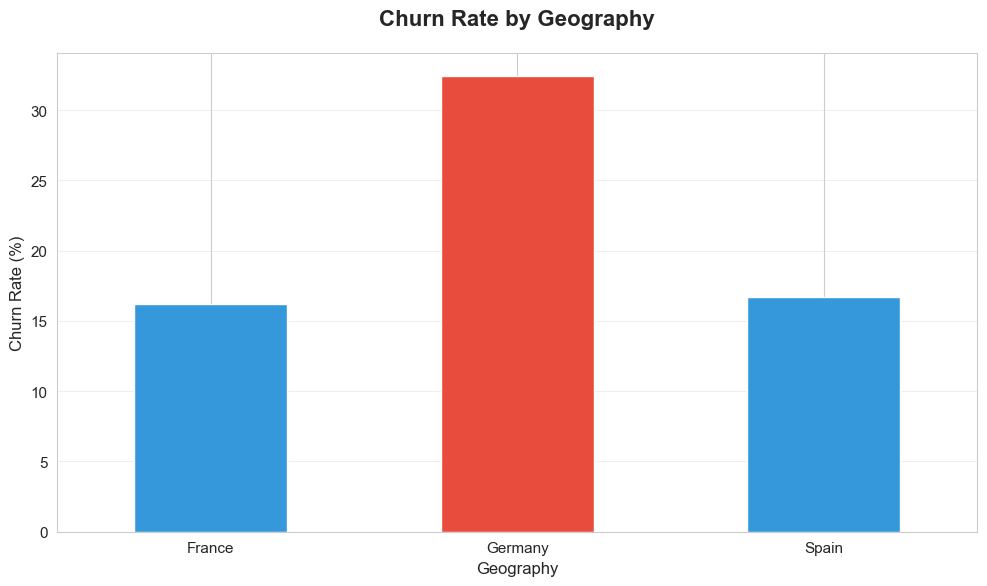

Highest churn: Germany at 32.44%


In [14]:
plt.figure(figsize=(10, 6))
churn_geo = df.groupby('Geography')['Exited'].mean() * 100
colors = ['#e74c3c' if x == churn_geo.max() else '#3498db' for x in churn_geo]
churn_geo.plot(kind='bar', color=colors)
plt.title('Churn Rate by Geography', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Geography', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Highest churn: {churn_geo.idxmax()} at {churn_geo.max():.2f}%")

### 7.2 Churn Rate by Age Group

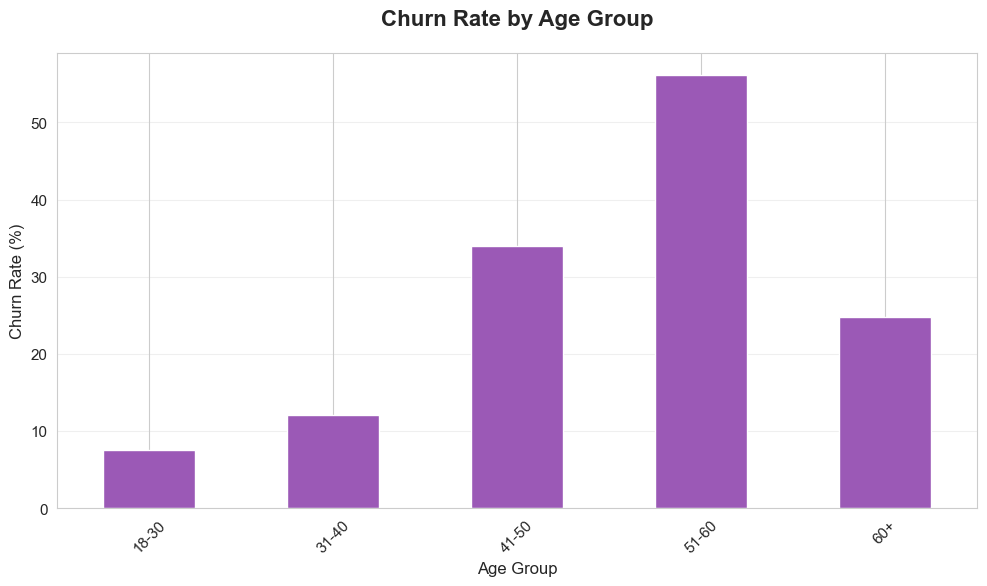

Highest churn age group: 51-60 at 56.21%


In [15]:
plt.figure(figsize=(10, 6))
churn_age = df.groupby('AgeGroup')['Exited'].mean() * 100
churn_age.plot(kind='bar', color='#9b59b6')
plt.title('Churn Rate by Age Group', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Highest churn age group: {churn_age.idxmax()} at {churn_age.max():.2f}%")

### 7.3 Active vs Inactive Members

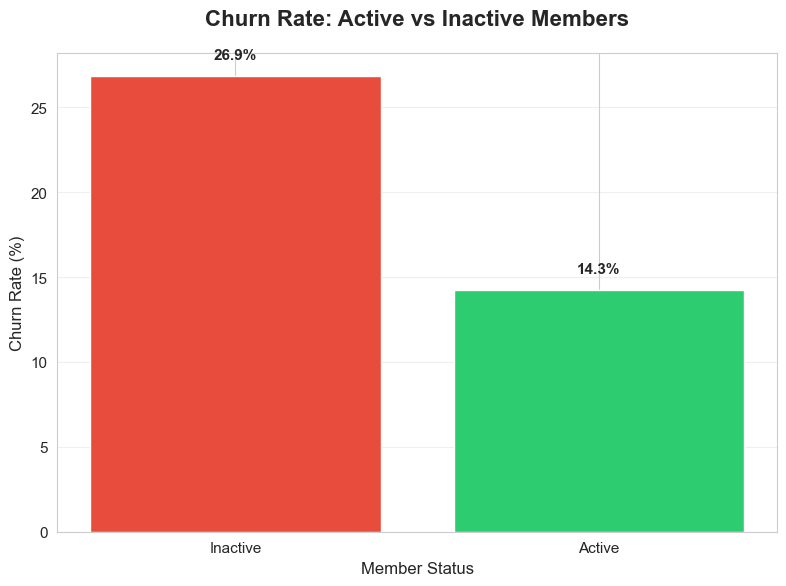

Inactive members churn at 26.87% vs 14.27% for active members


In [16]:
plt.figure(figsize=(8, 6))
activity_churn = df.groupby('IsActiveMember')['Exited'].mean() * 100
activity_labels = ['Inactive', 'Active']
colors = ['#e74c3c', '#2ecc71']
plt.bar(activity_labels, activity_churn, color=colors)
plt.title('Churn Rate: Active vs Inactive Members', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Member Status', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(activity_churn):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Inactive members churn at {activity_churn[0]:.2f}% vs {activity_churn[1]:.2f}% for active members")

### 7.4 Complaint Impact on Churn

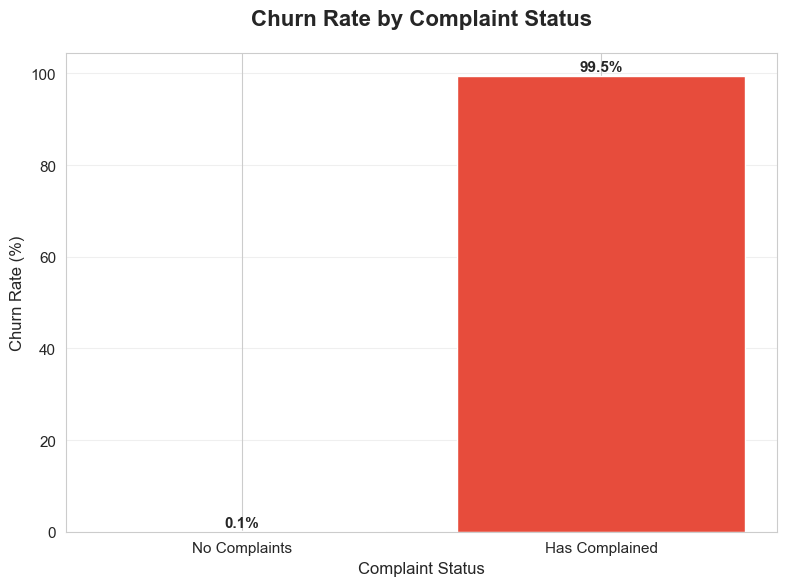

Customers with complaints churn at 99.51% vs 0.05% without complaints


In [17]:
plt.figure(figsize=(8, 6))
complaint_churn = df.groupby('Complain')['Exited'].mean() * 100
complaint_labels = ['No Complaints', 'Has Complained']
colors = ['#2ecc71', '#e74c3c']
plt.bar(complaint_labels, complaint_churn, color=colors)
plt.title('Churn Rate by Complaint Status', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Complaint Status', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.grid(axis='y', alpha=0.3)

# Add value labels
for i, v in enumerate(complaint_churn):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"Customers with complaints churn at {complaint_churn[1]:.2f}% vs {complaint_churn[0]:.2f}% without complaints")

### 7.5 Balance Distribution: Retained vs Churned

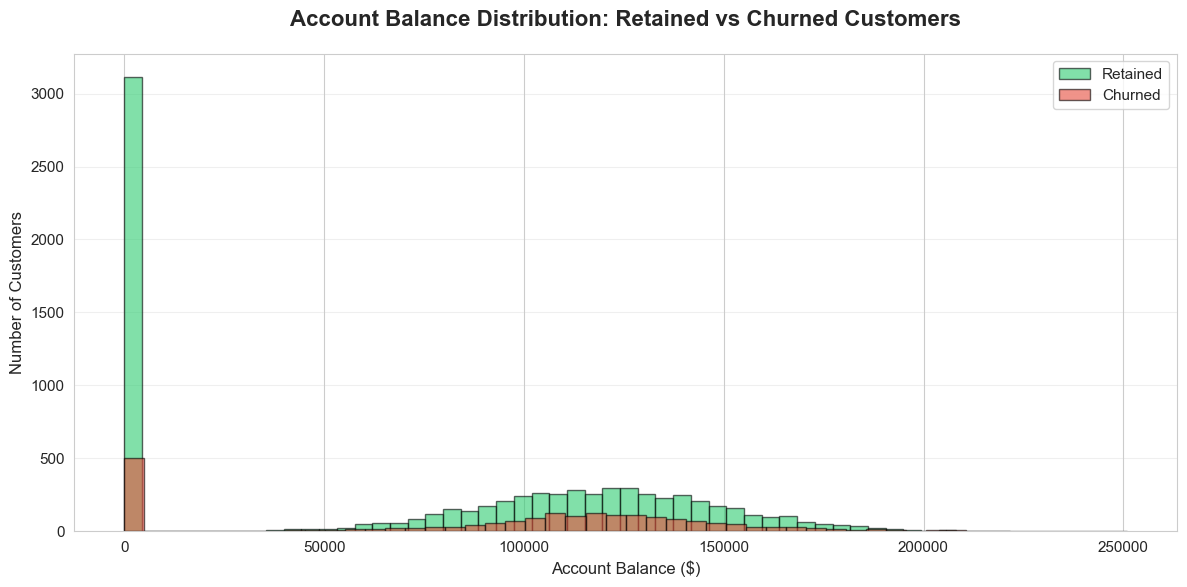

Average balance (Retained): $72,742.75
Average balance (Churned): $91,109.48


In [18]:
plt.figure(figsize=(12, 6))
df[df['Exited']==0]['Balance'].hist(bins=50, alpha=0.6, label='Retained', color='#2ecc71', edgecolor='black')
df[df['Exited']==1]['Balance'].hist(bins=50, alpha=0.6, label='Churned', color='#e74c3c', edgecolor='black')
plt.title('Account Balance Distribution: Retained vs Churned Customers', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Account Balance ($)', fontsize=12)
plt.ylabel('Number of Customers', fontsize=12)
plt.legend(fontsize=11)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"Average balance (Retained): ${df[df['Exited']==0]['Balance'].mean():,.2f}")
print(f"Average balance (Churned): ${df[df['Exited']==1]['Balance'].mean():,.2f}")

### 7.6 Churn Rate by Number of Products

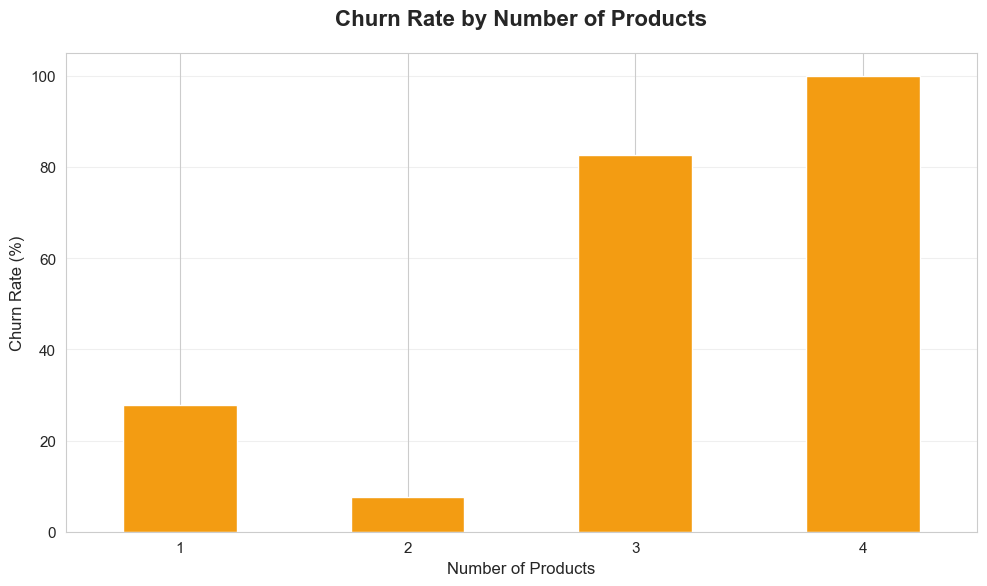


Product usage pattern:
  1 product(s): 27.71% churn rate
  2 product(s): 7.60% churn rate
  3 product(s): 82.71% churn rate
  4 product(s): 100.00% churn rate


In [19]:
plt.figure(figsize=(10, 6))
products_churn = df.groupby('NumOfProducts')['Exited'].mean() * 100
products_churn.plot(kind='bar', color='#f39c12')
plt.title('Churn Rate by Number of Products', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Number of Products', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nProduct usage pattern:")
for prod, rate in products_churn.items():
    print(f"  {prod} product(s): {rate:.2f}% churn rate")

### 7.7 Correlation Heatmap

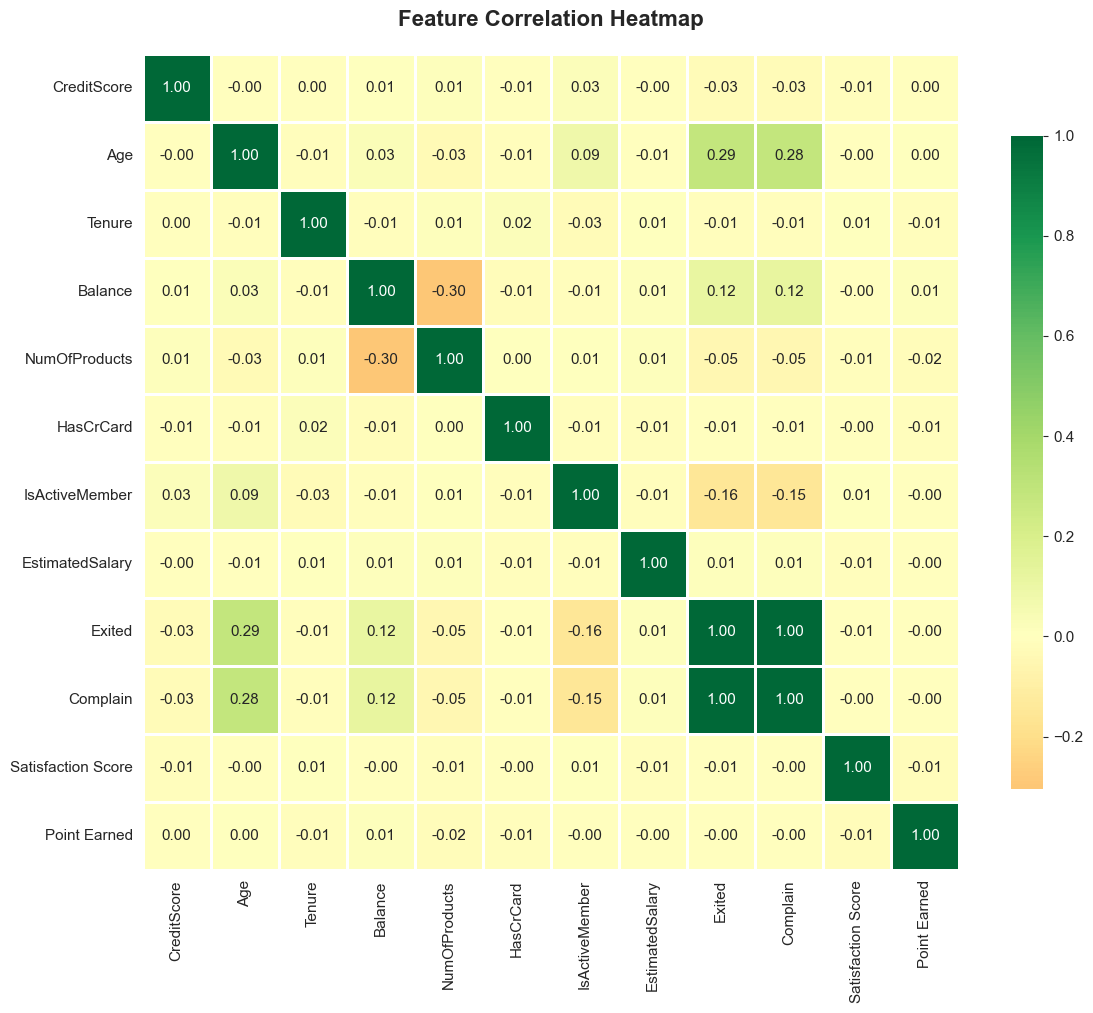


Top correlations with Churn (Exited):
Complain              0.995693
Age                   0.285296
Balance               0.118577
EstimatedSalary       0.012490
Point Earned         -0.004628
Satisfaction Score   -0.005849
HasCrCard            -0.006976
Tenure               -0.013656
CreditScore          -0.026771
NumOfProducts        -0.047611
IsActiveMember       -0.156356
Name: Exited, dtype: float64


In [20]:
# Select numeric columns for correlation
numeric_cols = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 
                'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited',
                'Complain', 'Satisfaction Score', 'Point Earned']

plt.figure(figsize=(12, 10))
correlation = df[numeric_cols].corr()
sns.heatmap(correlation, annot=True, fmt='.2f', cmap='RdYlGn', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Feature Correlation Heatmap', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

print("\nTop correlations with Churn (Exited):")
churn_corr = correlation['Exited'].sort_values(ascending=False)
print(churn_corr[churn_corr.index != 'Exited'])

### 7.8 Satisfaction Score vs Churn

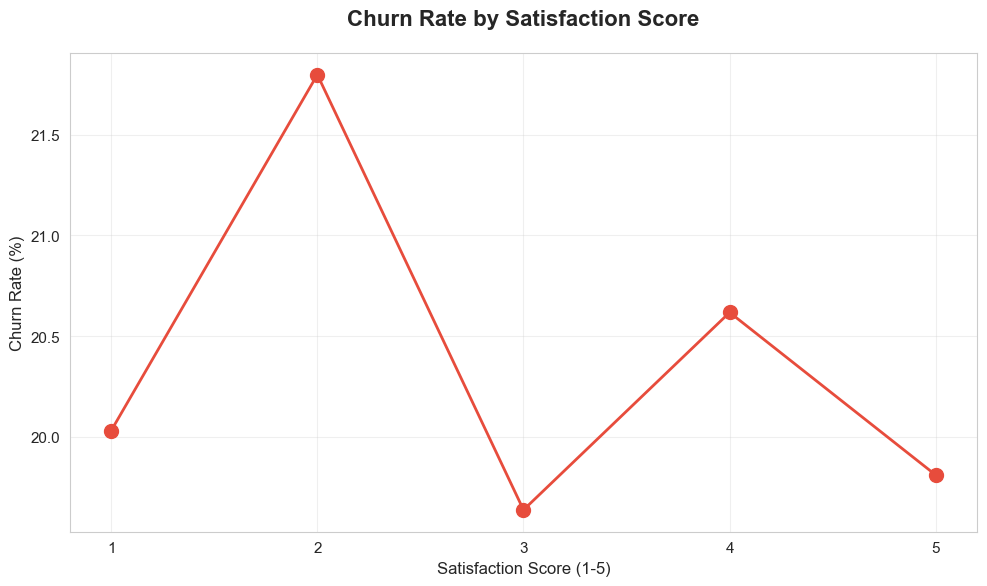


Satisfaction scores and churn:
  Score 1: 20.03% churn rate
  Score 2: 21.80% churn rate
  Score 3: 19.64% churn rate
  Score 4: 20.62% churn rate
  Score 5: 19.81% churn rate


In [21]:
plt.figure(figsize=(10, 6))
satisfaction_churn = df.groupby('Satisfaction Score')['Exited'].mean() * 100
plt.plot(satisfaction_churn.index, satisfaction_churn.values, marker='o', 
         linewidth=2, markersize=10, color='#e74c3c')
plt.title('Churn Rate by Satisfaction Score', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Satisfaction Score (1-5)', fontsize=12)
plt.ylabel('Churn Rate (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks([1, 2, 3, 4, 5])
plt.tight_layout()
plt.show()

print("\nSatisfaction scores and churn:")
for score, rate in satisfaction_churn.items():
    print(f"  Score {score}: {rate:.2f}% churn rate")

## 8. Key Insights and Business Recommendations

In [22]:
print("="*70)
print("KEY INSIGHTS - CUSTOMER CHURN ANALYSIS")
print("="*70)

# Calculate key metrics
highest_churn_geo = df.groupby('Geography')['Exited'].mean().idxmax()
highest_geo_rate = df.groupby('Geography')['Exited'].mean().max() * 100

inactive_churn = df[df['IsActiveMember']==0]['Exited'].mean() * 100
active_churn = df[df['IsActiveMember']==1]['Exited'].mean() * 100

complaint_churn_rate = df[df['Complain']==1]['Exited'].mean() * 100
no_complaint_rate = df[df['Complain']==0]['Exited'].mean() * 100

highest_age_group = df.groupby('AgeGroup')['Exited'].mean().idxmax()
highest_age_rate = df.groupby('AgeGroup')['Exited'].mean().max() * 100

products_max_churn = df.groupby('NumOfProducts')['Exited'].mean().idxmax()
products_max_rate = df.groupby('NumOfProducts')['Exited'].mean().max() * 100

print("\n1. GEOGRAPHIC FACTORS")
print(f"   • {highest_churn_geo} has the highest churn rate at {highest_geo_rate:.1f}%")
print("   • Geographic targeting needed for retention campaigns")

print("\n2. CUSTOMER ACTIVITY")
print(f"   • Inactive members churn at {inactive_churn:.1f}% vs {active_churn:.1f}% for active members")
print("   • Engagement programs critical for retention")

print("\n3. COMPLAINTS IMPACT")
print(f"   • Customers with complaints churn at {complaint_churn_rate:.1f}% vs {no_complaint_rate:.1f}% without")
print("   • Customer service quality directly impacts retention")

print("\n4. AGE DEMOGRAPHICS")
print(f"   • {highest_age_group} age group shows highest churn at {highest_age_rate:.1f}%")
print("   • Age-specific retention strategies recommended")

print("\n5. PRODUCT USAGE")
print(f"   • Customers with {products_max_churn} products have highest churn at {products_max_rate:.1f}%")
print("   • Product bundling strategies may need review")

print("\n" + "="*70)
print("RECOMMENDED ACTIONS")
print("="*70)

print("\n1. IMMEDIATE ACTIONS:")
print(f"   • Launch targeted retention campaign in {highest_churn_geo}")
print("   • Implement proactive outreach for inactive members")
print("   • Fast-track complaint resolution processes")

print("\n2. MEDIUM-TERM STRATEGIES:")
print(f"   • Develop engagement programs for {highest_age_group} demographic")
print("   • Review and optimize product offerings")
print("   • Enhance customer satisfaction measurement and response")

print("\n3. LONG-TERM INITIATIVES:")
print("   • Build predictive churn model for early intervention")
print("   • Implement personalized retention strategies by segment")
print("   • Continuous monitoring of satisfaction and complaint trends")

print("\n" + "="*70)
print("POTENTIAL IMPACT")
print("="*70)

current_churn = df['Exited'].mean() * 100
total_customers = len(df)
churned_customers = df['Exited'].sum()
avg_balance = df['Balance'].mean()

print(f"\nCurrent State:")
print(f"   • Churn Rate: {current_churn:.2f}%")
print(f"   • Churned Customers: {churned_customers:,}")
print(f"   • Average Customer Balance: ${avg_balance:,.2f}")
print(f"\nIf churn reduced by 5 percentage points (to {current_churn-5:.2f}%):")
saved_customers = int(total_customers * 0.05)
print(f"   • Customers Retained: ~{saved_customers:,}")
print(f"   • Estimated Balance Retained: ${saved_customers * avg_balance:,.2f}")

print("\n" + "="*70)

KEY INSIGHTS - CUSTOMER CHURN ANALYSIS

1. GEOGRAPHIC FACTORS
   • Germany has the highest churn rate at 32.4%
   • Geographic targeting needed for retention campaigns

2. CUSTOMER ACTIVITY
   • Inactive members churn at 26.9% vs 14.3% for active members
   • Engagement programs critical for retention

3. COMPLAINTS IMPACT
   • Customers with complaints churn at 99.5% vs 0.1% without
   • Customer service quality directly impacts retention

4. AGE DEMOGRAPHICS
   • 51-60 age group shows highest churn at 56.2%
   • Age-specific retention strategies recommended

5. PRODUCT USAGE
   • Customers with 4 products have highest churn at 100.0%
   • Product bundling strategies may need review

RECOMMENDED ACTIONS

1. IMMEDIATE ACTIONS:
   • Launch targeted retention campaign in Germany
   • Implement proactive outreach for inactive members
   • Fast-track complaint resolution processes

2. MEDIUM-TERM STRATEGIES:
   • Develop engagement programs for 51-60 demographic
   • Review and optimize pr

## 9. Conclusion

This analysis has identified several key factors contributing to customer churn:

1. **Geographic differences** show significant variation in churn rates
2. **Customer activity level** is a strong predictor of retention
3. **Complaints** have a dramatic impact on churn probability
4. **Age demographics** reveal specific at-risk segments
5. **Product usage patterns** correlate with customer loyalty

By implementing targeted retention strategies based on these insights, the bank can:
- Reduce overall churn rate
- Improve customer lifetime value
- Optimize marketing and service resources
- Enhance customer satisfaction and loyalty

**Next Steps:**
- Build predictive model to identify at-risk customers before they churn
- Implement A/B testing for retention campaigns
- Monitor KPIs and adjust strategies based on results

In [23]:
# Close database connection
conn.close()
print("✓ Analysis complete. Database connection closed.")

✓ Analysis complete. Database connection closed.
